<a href="https://colab.research.google.com/github/matiqiu/mcd-scanveg-ai-model-experiments/blob/main/exp02_mobilenet_finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1. Importaciones y configuración inicial
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pickle
import os
import shutil
from google.colab import files
import pandas as pd

In [ ]:
# 2. Autenticación de Kaggle
files.upload()  # Subir el token de Kaggle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (1).json


In [ ]:
# 3. Descarga del Dataset
!kaggle datasets download -d emmarex/plantdisease
!unzip -q plantdisease.zip

Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown
plantdisease.zip: Skipping, found more recently modified local copy (use --force to force download)
replace PlantVillage/Pepper__bell___Bacterial_spot/0022d6b7-d47c-4ee2-ae9a-392a53f48647___JR_B.Spot 8964.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# 4. Preparación del Dataset
src_dir = '/content/PlantVillage'
dst_dir = '/content/tomate_10clases'
tomato_classes = [
    'Tomato_Bacterial_spot',
    'Tomato_Early_blight',
    'Tomato_Late_blight',
    'Tomato_Leaf_Mold',
    'Tomato_Septoria_leaf_spot',
    'Tomato_Spider_mites_Two_spotted_spider_mite',
    'Tomato__Target_Spot',
    'Tomato__Tomato_YellowLeaf__Curl_Virus',
    'Tomato__Tomato_mosaic_virus',
    'Tomato_healthy'
]

os.makedirs(dst_dir, exist_ok=True)
for cls in tomato_classes:
    src_cls_path = os.path.join(src_dir, cls)
    dst_cls_path = os.path.join(dst_dir, cls)
    if os.path.isdir(src_cls_path):
        if os.path.exists(dst_cls_path):
            shutil.rmtree(dst_cls_path)
        shutil.copytree(src_cls_path, dst_cls_path)
    else:
        print(f"⚠️  Clase no encontrada: {cls}")

print("Carpetas copiadas:")
print(sorted(os.listdir(dst_dir)))

Carpetas copiadas:
['Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


In [ ]:
# 5. Generadores de Datos
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 10
EPOCHS = 14  # Total de épocas

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    dst_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    dst_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 12813 images belonging to 10 classes.
Found 3198 images belonging to 10 classes.


In [ ]:
# 6. Construcción del Modelo
base_model = MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

In [ ]:
# Primera Fase: Congelar todas las capas del modelo base
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),  # Tasa de aprendizaje más alta
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# 7. Callbacks y Entrenamiento (Primera Fase)
EXPERIMENT_NAME = "exp02_mobilenet_finetune"
model_path_phase1 = f'/content/drive/MyDrive/PROYECTO/{EXPERIMENT_NAME}_phase1.keras'
history_path_phase1 = f'/content/drive/MyDrive/PROYECTO/{EXPERIMENT_NAME}_phase1_history.pkl'

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint(model_path_phase1, save_best_only=True)
]

history1 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS // 2,  # Primera mitad de las épocas
    callbacks=callbacks
)

# Guardar el progreso después de la primera fase
model.save(model_path_phase1)
with open(history_path_phase1, 'wb') as f:
    pickle.dump(history1.history, f)

Epoch 1/7
401/401 ━━━━━━━━━━━━━━━━━━━━ 933s 2s/step - accuracy: 0.5542 - loss: 1.3749 - val_accuracy: 0.8136 - val_loss: 0.5753
Epoch 2/7
401/401 ━━━━━━━━━━━━━━━━━━━━ 908s 2s/step - accuracy: 0.7949 - loss: 0.6257 - val_accuracy: 0.8446 - val_loss: 0.4600
Epoch 3/7
401/401 ━━━━━━━━━━━━━━━━━━━━ 890s 2s/step - accuracy: 0.8183 - loss: 0.5181 - val_accuracy: 0.8487 - val_loss: 0.4338
Epoch 4/7
401/401 ━━━━━━━━━━━━━━━━━━━━ 896s 2s/step - accuracy: 0.8359 - loss: 0.4899 - val_accuracy: 0.8746 - val_loss: 0.3986
Epoch 5/7
401/401 ━━━━━━━━━━━━━━━━━━━━ 898s 2s/step - accuracy: 0.8382 - loss: 0.4709 - val_accuracy: 0.8712 - val_loss: 0.3828
Epoch 6/7
401/401 ━━━━━━━━━━━━━━━━━━━━ 937s 2s/step - accuracy: 0.8476 - loss: 0.4518 - val_accuracy: 0.8777 - val_loss: 0.3614
Epoch 7/7
401/401 ━━━━━━━━━━━━━━━━━━━━ 933s 2s/step - accuracy: 0.8482 - loss: 0.4420 - val_accuracy: 0.8715 - val_loss: 0.3658


In [ ]:
# 8. Segunda Fase: Descongelar las últimas 20 capas del modelo base
print("Capas entrenables antes de descongelar:", len(model.trainable_variables))
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False
print("Capas entrenables después de descongelar:", len(model.trainable_variables))


model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Tasa de aprendizaje más baja
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Capas entrenables antes de descongelar: 23
Capas entrenables después de descongelar: 23


In [ ]:
# 9. Callbacks y Entrenamiento (Segunda Fase)
model_path_phase2 = f'/content/drive/MyDrive/PROYECTO/{EXPERIMENT_NAME}_phase2.keras'
history_path_phase2 = f'/content/drive/MyDrive/PROYECTO/{EXPERIMENT_NAME}_phase2_history.pkl'

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint(model_path_phase2, save_best_only=True)
]

# Asegurarse que la época inicial es la correcta
initial_epoch = history1.epoch[-1] + 1

history2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,  # Entrenar hasta el final de las épocas totales
    initial_epoch=initial_epoch,  # Comenzar desde la época siguiente a la última de la fase 1
    callbacks=callbacks
)

# Guardar el progreso final después de la segunda fase
model.save(model_path_phase2)
with open(history_path_phase2, 'wb') as f:
    pickle.dump(history2.history, f)

Epoch 8/14
401/401 ━━━━━━━━━━━━━━━━━━━━ 1058s 3s/step - accuracy: 0.5943 - loss: 1.7118 - val_accuracy: 0.8587 - val_loss: 0.4206
Epoch 9/14
401/401 ━━━━━━━━━━━━━━━━━━━━ 1111s 3s/step - accuracy: 0.8266 - loss: 0.5134 - val_accuracy: 0.8734 - val_loss: 0.3613
Epoch 10/14
401/401 ━━━━━━━━━━━━━━━━━━━━ 1066s 3s/step - accuracy: 0.8493 - loss: 0.4299 - val_accuracy: 0.8818 - val_loss: 0.3496
Epoch 11/14
401/401 ━━━━━━━━━━━━━━━━━━━━ 1075s 3s/step - accuracy: 0.8647 - loss: 0.4081 - val_accuracy: 0.8862 - val_loss: 0.3403
Epoch 12/14
401/401 ━━━━━━━━━━━━━━━━━━━━ 1047s 3s/step - accuracy: 0.8765 - loss: 0.3643 - val_accuracy: 0.8840 - val_loss: 0.3330
Epoch 13/14
401/401 ━━━━━━━━━━━━━━━━━━━━ 1044s 3s/step - accuracy: 0.8901 - loss: 0.3253 - val_accuracy: 0.9034 - val_loss: 0.2927
Epoch 14/14
401/401 ━━━━━━━━━━━━━━━━━━━━ 1071s 3s/step - accuracy: 0.8936 - loss: 0.3152 - val_accuracy: 0.9071 - val_loss: 0.2713


In [ ]:
# 10. Evaluación y Visualización
val_gen.reset()
y_pred_prob = model.predict(val_gen, verbose=0)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = val_gen.classes

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='weighted')
rec = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {acc}")
print(f"Precision: {prec}")
print(f"Recall: {rec}")
print(f"F1-score: {f1}")

Accuracy: 0.9027517198248906
Precision: 0.9026526283223637
Recall: 0.9027517198248906
F1-score: 0.9001995551337728


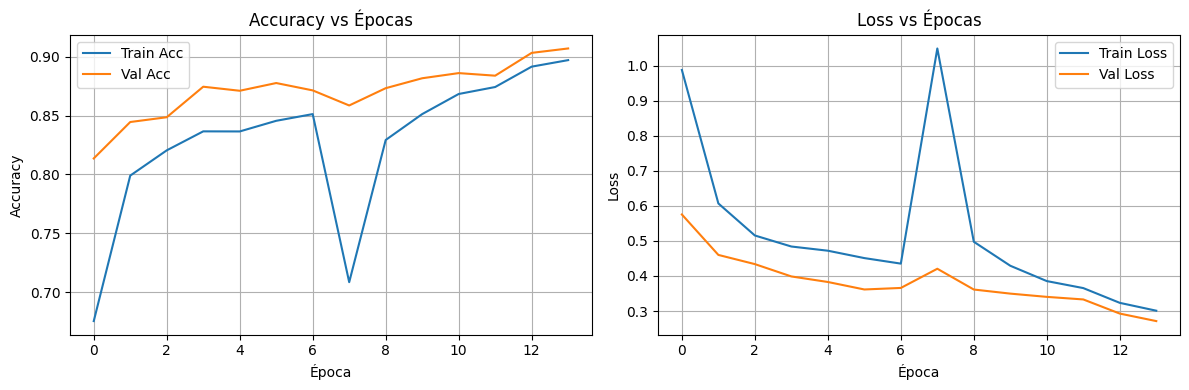

In [ ]:
# 11. Gráficos de métricas
hist_df1 = pd.DataFrame(history1.history)
hist_df2 = pd.DataFrame(history2.history)
hist_df = pd.concat([hist_df1, hist_df2], ignore_index=True)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(hist_df['accuracy'], label='Train Acc')
plt.plot(hist_df['val_accuracy'], label='Val Acc')
plt.title('Accuracy vs Épocas'); plt.xlabel('Época'); plt.ylabel('Accuracy')
plt.legend(); plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(hist_df['loss'], label='Train Loss')
plt.plot(hist_df['val_loss'], label='Val Loss')
plt.title('Loss vs Épocas'); plt.xlabel('Época'); plt.ylabel('Loss')
plt.legend(); plt.grid(True)
plt.tight_layout()
plt.savefig(f'/content/{EXPERIMENT_NAME}_curvas.png', dpi=300)
plt.show()

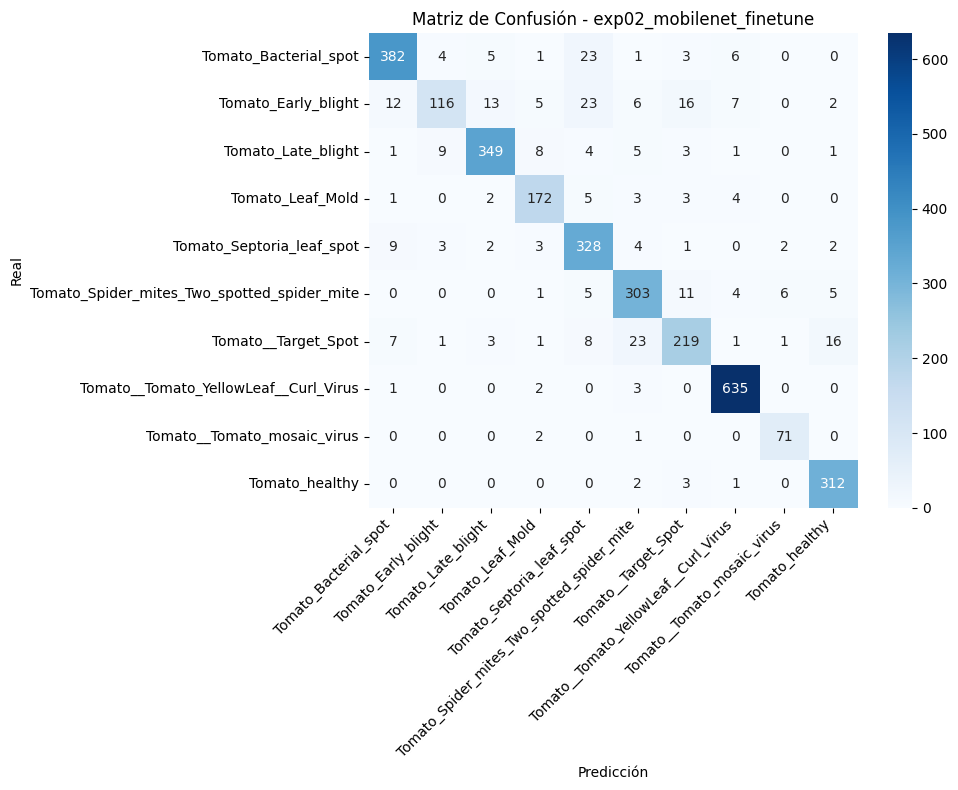

In [ ]:
# 12. Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=val_gen.class_indices.keys(), yticklabels=val_gen.class_indices.keys())
plt.title(f'Matriz de Confusión - {EXPERIMENT_NAME}')
plt.xlabel('Predicción'); plt.ylabel('Real')
plt.xticks(rotation=45, ha='right'); plt.tight_layout()
plt.savefig(f'/content/{EXPERIMENT_NAME}_matrix.png', dpi=300)
plt.show()